In [1]:
from src.System import *

In [2]:
Gr=importa("gr")
Gr.name="Grafene"
hBn=importa("hBn")
hBn.name="hBN"
Ph=importa("Ph")
Ph.name="Ph"

Se leerá el archivo gr.vasp
--Red creada a partir del archivo 'gr.vasp'--
Se leerá el archivo hBn.vasp
--Red creada a partir del archivo 'hBn.vasp'--
Se leerá el archivo Ph.vasp
--Red creada a partir del archivo 'Ph.vasp'--


Puntos de red en comun encontrados: 9
Posibles Matrices de trasformación calculadas:10
Opción recomendada:
Matriz de trasformación:
	26	7
	-2	11

Sistema [hBN,Ph(rot 3.8°),Grafene(rot 18.1°)] 
Celda unitaria:


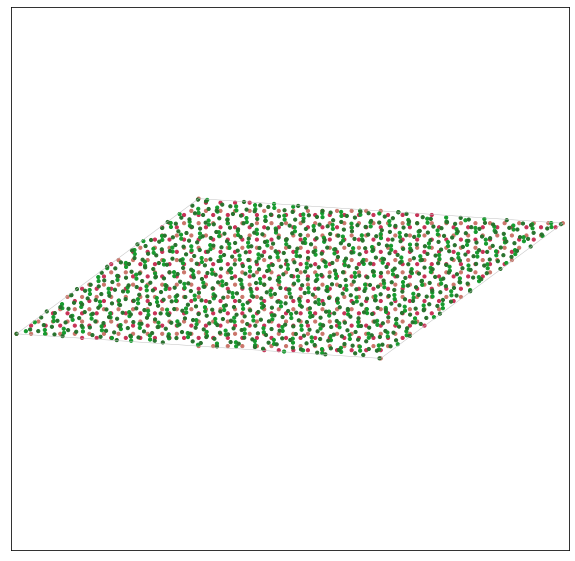

Espacio Reciproco:
Calculando...
...Pintando capa 1 (hBN)
...Pintando capa 2 (Ph(rot 3.8°))
...Pintando capa 3 (Grafene(rot 18.1°))
...Terminado


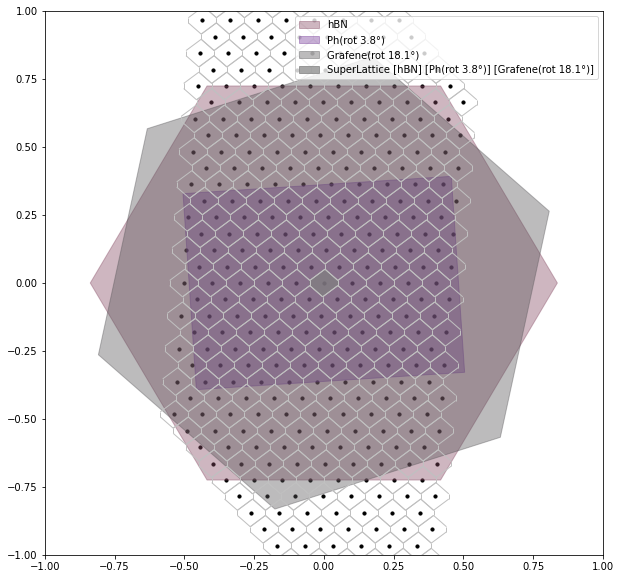

0

In [3]:
hpg=system([hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
hpg.muestraSR(range_search=30,eps=0.03)

In [ ]:
s=system([grafeno(),grafeno().mRot(13.17),grafeno().mRot(21.78)])

In [ ]:
M=[[6,13],[36,47]]
hpg.createSuperLattice(M)
hpg.show()

In [ ]:
sp=superMesh((100,0),(0,100),[hBn,Ph.mRot(3.8),Gr.mRot(18.1)])
sp.showme()

In [ ]:
s.muestraSR()

In [ ]:
sr1=s1.SuperRed
s2=system([sr1,grafeno().mRot(21.78)])

In [ ]:
s2.muestraSR()

In [ ]:
def its_hexagonal_system(self):
    '''
    Señala si el sistema está conformado sólo por redes hexagonales.
    '''
    err = 10**-6
    for r in self.redes:
        if abs(120.0-r.inAngle)>err:
            return False
    return True

In [ ]:
s0=system([grafeno(),grafeno3(),hexa6(1.26),blackPhospho()])
its_hexagonal_system(s0)

In [4]:
def corresponding_points(l1, l2, M):
    a1, b1 = mTv(M)
    a2, b2 = (calcCD(l1,l2,a1),calcCD(l1,l2,b1))
    return vTm(a2,b2)

def optimize_system(s0:system, T):
    s = s0.clon()
    s.name = s.name + "Opt"
    if len(s.redes)<2:
        return -1
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        #Guarda la matríz de deformación
        deformaciones.append(S_i)
        #Actualiza la red en la capa con los nuevos vectores primitivos
        a, b = mTv(V_i_Op)
        s.redes[i].setNewVectors(a,b)
        s.redes[i].name = s.redes[i].name + "(Opt)"
    #Creando super Red para el sistema deformado
    s.createSuperLattice(T)
    s.show()
    return s, deformaciones

Matriz de trasformación:
	26	7
	-2	11

Sistema [hBN,Ph(rot 3.8°),Grafene(rot 18.1°)]Opt 
Celda unitaria:


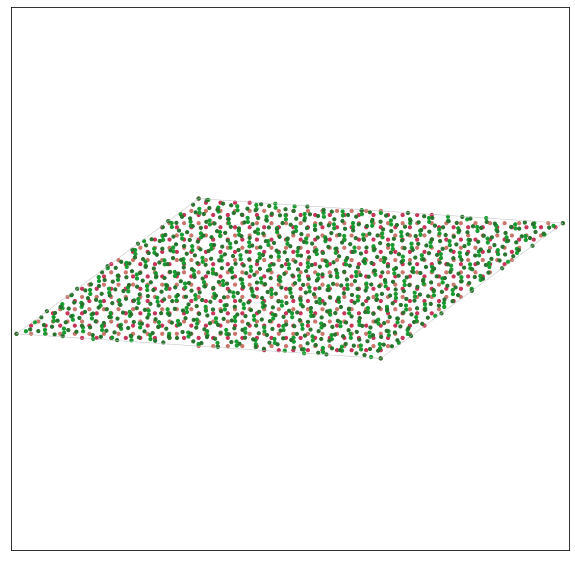

Espacio Reciproco:
Calculando...
...Pintando capa 1 (hBN)
...Pintando capa 2 (Ph(rot 3.8°)(Opt))
...Pintando capa 3 (Grafene(rot 18.1°)(Opt))
...Terminado


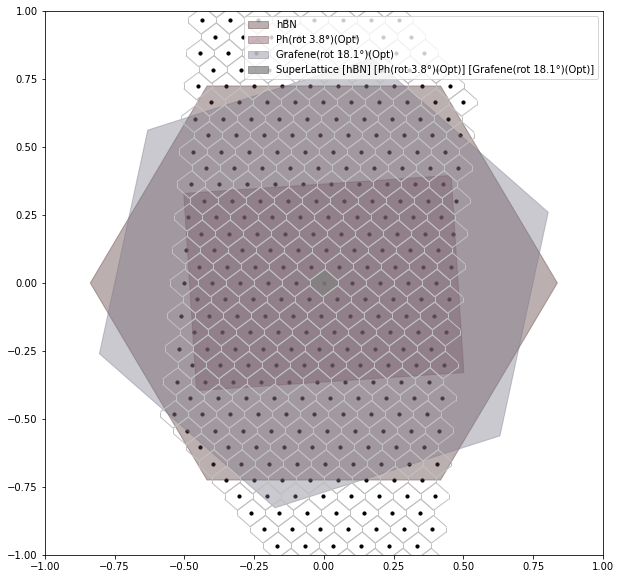

In [11]:
hpg2, dfm = optimize_system(hpg,hpg.loMat[0])

In [ ]:
V_0 = vTm(hpg2.redes[0].a,hpg2.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg2.redes[i].a,hpg2.redes[i].b)
    T_i = corresponding_points(hpg2.redes[0], hpg2.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [ ]:
V_0 = vTm(hpg.redes[0].a,hpg.redes[0].b)
V_s = m2M(V_0,hpg.loMat[0])
u,v = mTv(V_s)
print("Vectores esperados:{},{}".format(u,v))
for i in range(1,len(hpg2.redes)):
    V_i = vTm(hpg.redes[i].a,hpg.redes[i].b)
    T_i = corresponding_points(hpg.redes[0], hpg.redes[i],hpg.loMat[0])
    u,v = mTv(m2M(V_i,T_i))
    print("Vectores capa{}:{},{}".format(i,u,v))

In [5]:
def calc_def(s:system, T):
    if len(s.redes)<2:
        return None, None
    V_0 = vTm(s.redes[0].a,s.redes[0].b)
    V_s = m2M(V_0,T)
    deformaciones = []
    Ts = []
    for i in range(1,len(s.redes)):
        V_i = vTm(s.redes[i].a,s.redes[i].b)
        #Calculamos la Matriz de trasformación de la capa actual y la guardamos.
        T_i = corresponding_points(s.redes[0], s.redes[i], T)
        Ts.append(T_i)
        #Calculamos la matriz de deformación y la guardamos
        V_i_Op = m2M(V_s,inv2x2(T_i))
        S_i = m2M(inv2x2(V_i),V_i_Op)
        deformaciones.append(S_i)
        print
    return [Ts, deformaciones]

def muestra2(s):
    '''
    Muestra una tabla con las caracteristicas de los mejores resultados para las trasnformaciones requeridas para la super Red que describa el sistema r2 sobre r1.
    lor -> Lista de resultados obtenidos de la funciòn 'analiza'
    r1  -> Red1
    r2  -> Red2
    '''
    cont = 1
    for M in s.loMat:
        print("\n**Opción {}. T <- Matriz loMat[{}] del sistema".format(cont,cont-1))
        table = PrettyTable(["Red","T","Deformación","s","#Átomos"])
        res = calc_def(s,M)
        err = 0.0
        totalAtms = s.redes[0].nOAtms()*det(M)
        table.add_row(["Capa 0:\n" + s.redes[0].name,
                       mtoStr(M),
                       mtoStr([[1,0],[0,1]]),
                       "{:.3f}%".format(0.0),
                       totalAtms])
        
        for i in range(len(res)):
            atms = s.redes[i+1].nOAtms() * det(res[0][i])
            totalAtms += atms
            c_err = (det(res[1][i])-1)*100
            err += abs(c_err)
            table.add_row(["Capa {}:\n".format(i+1) + s.redes[i+1].name,
                           mtoStr(res[0][i]),
                           mtoStr(res[1][i]),
                           "{:.3f}%".format(c_err),
                           atms])
        cont+=1
        print(table)
        print("\t\tTotal de Átomos:{}\tDeformación Promedio:{:.5f}%".format(totalAtms,err/len(res)))


In [6]:
muestra2(hpg)


**Opción 1. T <- Matriz loMat[0] del sistema
+--------------------+-------------+---------------------+---------+---------+
|        Red         |      T      |     Deformación     |    s    | #Átomos |
+--------------------+-------------+---------------------+---------+---------+
|      Capa 0:       | |  26    7| |     |   1    0|     |  0.000% |   600   |
|        hBN         | |  -2   11| |     |   0    1|     |         |         |
|                    |             |                     |         |         |
|      Capa 1:       | |  19   10| | | 1.00342  0.00448| | -0.207% |   460   |
|    Ph(rot 3.8°)    | |  -2    5| | | 0.00214  0.99454| |         |         |
|                    |             |                     |         |         |
|      Capa 2:       | |  29   12| | | 1.00336 -0.00037| |  1.087% |   612   |
| Grafene(rot 18.1°) | | -11    6| | | 0.00156  1.00748| |         |         |
|                    |             |                     |         |         |
+-----

In [ ]:
muestra2(hpg2)

In [ ]:
mtoStr([[5.2222,3.4581001],[7,6]])

In [ ]:
strS(5.2222)

In [ ]:
type(5.2222)

In [7]:
hpg.resultados

[[[7, 11], 0.018673979199760563],
 [[1, -25], 0.019069670351732647],
 [[26, -2], 0.018552445785559653],
 [[18, 12], 0.026786425764754103],
 [[3, -29], 0.02463203103005901],
 [[19, -13], 0.02079101727346818],
 [[9, 26], 0.027253479512691067],
 [[14, 22], 0.026408994647774464],
 [[25, 23], 0.01259602605910327]]

In [8]:
(c,d) = calcCD(hpg.redes[0],hpg.redes[1],(7, 11))
p_1 = m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11))
p_2 = m2V(hpg.redes[1].a,hpg.redes[1].b,(c,d))
dist(p_1,p_2)

0.18640609197935795

In [10]:
cAng(m2V(hpg.redes[0].a,hpg.redes[0].b,(7, 11)),m2V(hpg.redes[0].a,hpg.redes[0].b,(26, -2)))

41.27430880836384

In [21]:
hpg.SuperRed.reciprocalVectors

[(0.04603978844881077, -0.060411695197323236, 0.0),
 (-0.008370870627056503, -0.12082321651145529, 0.0),
 (-0.0, 0.0, 0.3141592653589793)]

In [20]:
hpg2.SuperRed.reciprocalVectors

[(0.04603978844881077, -0.060411695197323236, 0.0),
 (-0.008370870627056503, -0.12082321651145529, 0.0),
 (-0.0, 0.0, 0.3141592653589793)]

In [32]:
hpg2.SuperRed.exporta()
hpg.SuperRed.exporta()

1

In [43]:
va,vb,th=hpg2.redes[2].a,hpg2.redes[2].b, cAng(hpg2.redes[2].a,hpg2.redes[2].b)
print("Red Grafeno Optimizada:\n\t a={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5}".format(va,vb,long(va),long(vb),th))

Red Grafeno Optimizada:
	a=(2.3507403021068622, 0.771832839685294),b=(0.5110344143362751, 2.428795082679412)
	|a|=2.47421,|b|=2.48198,Theta=59.941


In [42]:
va,vb,th=hpg.redes[2].a,hpg.redes[2].b,cAng(hpg.redes[2].a,hpg.redes[2].b)
print("Red Grafeno Original:\n\ta={},b={}\n\t|a|={:.5f},|b|={:.5f},Theta={:.5f}".format(va,vb,long(va),long(vb),th))

Red Grafeno Original:
	a=(2.3420734695145082, 0.7655076073233918),b=(0.5080910711090603, 2.411048215345949)
	|a|=2.46400,|b|=2.46400,Theta=60.00000000000001
